# Índice <a name="Contents"></a>
1. [Bibliotecas](#import)
2. [Carregando o dataframe](#read)
3. [Transformando Categóricas em Flag](#categorizados)
4. [Descritiva](#descritivas)
5. [Modelo](#modelo)
6. [Método Split](#split)
7. [Variação k-fold](#k-fold)
6. [Prós e Contras, qual usar ?](#prós)



# Bibliotecas <a name="import"></a>

<div style="text-align: right"
     
[Voltar ao índice](#Contents)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

from sklearn.tree import plot_tree
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold


%matplotlib inline

# Carregando os dataframes <a name="read"></a>
<div style="text-align: right"
     
[Voltar ao índice](#Contents)

In [2]:
# Carregando o Data Frame de Treino
df_treino = pd.read_csv("desafio_manutencao_preditiva_treino.csv")
df_treino.head()

# Carregando o Data Frame de Test
df_test = pd.read_csv("desafio_manutencao_preditiva_teste.csv")

In [3]:
# Informações sobre o Data Frame e eliminando possíveis linhas duplicadas
df_treino.drop_duplicates()
df_treino.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6667 entries, 0 to 6666
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   udi                    6667 non-null   int64  
 1   product_id             6667 non-null   object 
 2   type                   6667 non-null   object 
 3   air_temperature_k      6667 non-null   float64
 4   process_temperature_k  6667 non-null   float64
 5   rotational_speed_rpm   6667 non-null   int64  
 6   torque_nm              6667 non-null   float64
 7   tool_wear_min          6667 non-null   int64  
 8   failure_type           6667 non-null   object 
dtypes: float64(3), int64(3), object(3)
memory usage: 468.9+ KB


#### Nota-se que o Data Frame não possui dados nulos, e 3 variáveis categóricas.

# Variáveis categoricas para dummie <a name="categorizados"></a>
<div style="text-align: right"
     
[Voltar ao índice](#Contents)

#### A variável categórica "type" precisa passar por tratamento para se enquadrar nas exigências do modelo. As outras variáveis explicativas não numéricas são apenas identificadores dos produtos e n serão usadas no modelo.

In [4]:
#Transformando variáveis categóricas em variáveis flag
df_treino_encoded = pd.get_dummies(df_treino, columns=['type'])
df_test_encoded = pd.get_dummies(df_test, columns=['type'])

df_test_encoded.head()

,udi,product_id,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,type_H,type_L,type_M
0,446,L47625,297.5,308.6,1793,26.7,70,0,1,0
1,7076,L54255,300.7,310.5,1536,47.4,192,0,1,0
2,1191,L48370,297.2,308.4,1460,42.1,41,0,1,0
3,2618,L49797,299.4,309.1,1670,35.9,68,0,1,0
4,5067,L52246,304.1,313.1,1550,30.9,9,0,1,0


# Descritiva dos dados <a name="descritivas"></a>
<div style="text-align: right"
     
[Voltar ao índice](#Contents)

### Análise descritiva e gráfica das principais variáveis do modelo

#### Apenas 232 produtos do Data Set possuem algum tipo de falha, sendo 3,48 % do total.

In [5]:
#Separando os produtos que apresentam falhas e não falhas
falhas = df_treino.loc[df_treino['failure_type'] != 'No Failure']  
nfalhas = df_treino.loc[df_treino['failure_type'] == 'No Failure']
print("O número de produtos com falhas é", falhas.shape[0])
print("O número de produtos sem falhas é", nfalhas.shape[0])
porcentagem_falhas = (falhas.shape[0] / df_treino.shape[0]) * 100
print("A porcentagem de falhas em relação ao todo é", porcentagem_falhas)

O número de produtos com falhas é 232
O número de produtos sem falhas é 6435
A porcentagem de falhas em relação ao todo é 3.479826008699565


#### Tipo de produtos e falhas:

Text(0.5, 1.0, 'QUANTIDADE DE CADA TIPO DE PRODUTO COM FALHA')

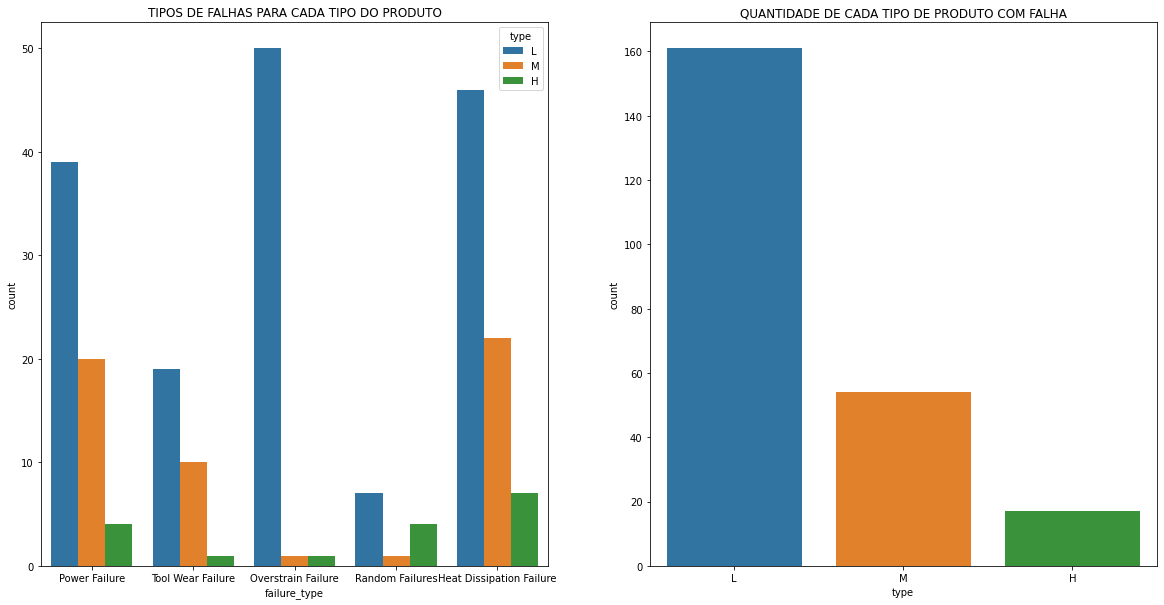

In [6]:
# Contagem dos tipos de falha ('failure_type') por tipo do produto ('type')
fig, ax = plt.subplots(1, 2,figsize = (20,10))
sns.countplot(x= 'failure_type', hue = 'type', data= falhas,ax=ax[0])
ax[0].set_title('TIPOS DE FALHAS PARA CADA TIPO DO PRODUTO')
# Contagem dos tipos de produto
sns.countplot(x='type',data= falhas, ax=ax[1])
ax[1].set_title('QUANTIDADE DE CADA TIPO DE PRODUTO COM FALHA')


### Os gráficos demonstram a quantidade de cada produto com falhas e a frequência de ocorrencia das falhas de acordo com cada tipo do produto, com isso podemos perceber que: 

#### > A grande maioria dos produtos com falhas são do tipo L e a minoria do tipo H
#### > A dissipação de calor é a maior causa geral de falhas, como também é a principal entre os produtos do tipo M e H
#### > A falha de sobrecarga é a maior causa dos produtos do tipo L, porém pouco afeta os produtos do tipo M e H


### Mínimo das temperaturas por tipo:

      air_temperature_k  process_temperature_k
type                                          
H                 302.0                  309.8
L                 301.4                  309.9
M                 300.8                  309.4


<AxesSubplot:xlabel='type'>

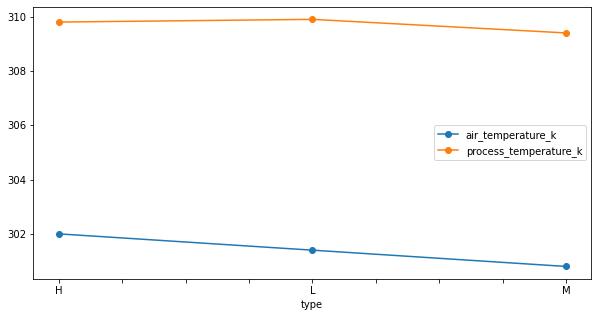

In [7]:
#Agrupando temperaturas por tipo de produto e observando as temperaturas mínimas que causam falha por dissipação de calor
heat_dissipation = falhas.loc[falhas['failure_type'] == 'Heat Dissipation Failure']
temps = heat_dissipation[['air_temperature_k','process_temperature_k','type']]
min_t = temps.groupby('type').min()
print(min_t)
min_t.plot(figsize = (10,5), marker='o')

#### Os tipos de produtos começam a apresentar falha por dissipação de calor por volta de 309 K da temperatura de processo e a temperatura do ar 300 K, 301 K e 302 K respectivamente dos produtos H, L, M.

### Comparação dos atributos mecânicos:

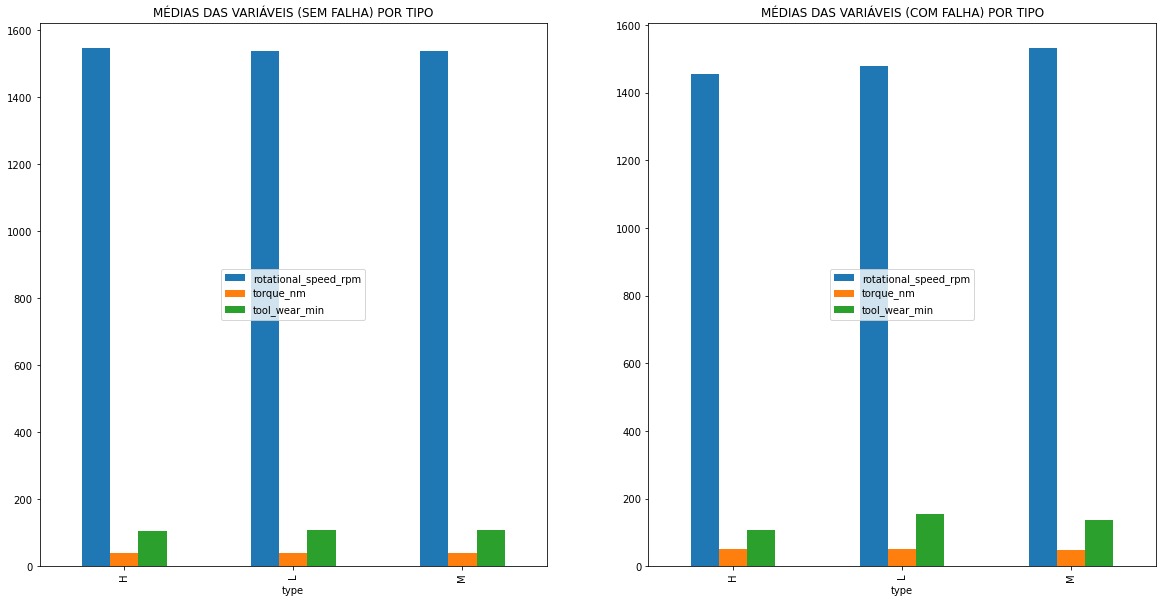

In [8]:
# Agrupando as variáveis mecânicas por tipo e calculando a média 
mecanico_f = falhas[['rotational_speed_rpm','torque_nm','tool_wear_min','type']]
mecanico_nf = nfalhas[['rotational_speed_rpm','torque_nm','tool_wear_min', 'type']]
tipo_mec_nf = mecanico_nf.groupby('type')
tipo_mec_f = mecanico_f.groupby('type')

fig, ax = plt.subplots(1, 2, figsize=(20,10))

tipo_mec_nf[['rotational_speed_rpm','torque_nm','tool_wear_min']].mean().plot(kind='bar', ax=ax[0])
ax[0].set_title('MÉDIAS DAS VARIÁVEIS (SEM FALHA) POR TIPO')
ax[0].legend(loc='center')

tipo_mec_f[['rotational_speed_rpm','torque_nm','tool_wear_min']].mean().plot(kind='bar', ax=ax[1])
ax[1].set_title('MÉDIAS DAS VARIÁVEIS (COM FALHA) POR TIPO')
ax[1].legend(loc='center')


### Os dois gráficos explicitam bem como são em média as condições mecânicas dos equipamentos sem e com falhas

#### > A velocidade de rotação com exceção do produto do tipo M, tende a cair em produtos com falhas
#### > O torque e o desgaste por minutos tendem a aumentar nos produtos com falhas

# Modelo <a name="modelo"></a>
<div style="text-align: right"
     
[Voltar ao índice](#Contents)

### Para resolver o modelo foi escolhido a ÁRVORE DE DECISÃO, por motivo de a variável resposta ter saídas prédeterminadas.

####  A variável resposta é 'failure_type' e desejamos saber qual tipo de falha os produtos novos irão apresentar. Como não possuímos os dados do y_test na base de teste, iremos utilizar dois métodos para avaliar o modelo e decidir qual o melhor a ser usado:

#### - Separar a base de treino, em treino e teste para avaliar o modelo.
#### - Utilizar a validação cruzada com o método de "K-fold" para avaliar apenas o modelo de treino e então implementar na base de teste.

#### Separar a base de treino aumenta a variedade de métricas de avaliação, porém diminui a quantidade de dados. E utilizar a validação cruzada aumenta a robustez dos dados porém, não se pode comparar com os resultados reais.

# Método split <a name="split"></a>
<div style="text-align: right"
     
[Voltar ao índice](#Contents)

In [9]:
X = df_treino_encoded.drop(['failure_type','udi','product_id'], axis=1) # variáveis independentes e retirando as não utilizadas
y = df_treino_encoded['failure_type'] # a variável alvo

In [10]:
#Separando em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

#### Utilizando o pacote DecisionTreeClassifier da biblioteca sklearn para instanciar o modelo, por default o DecisionTreeClassifier  utiliza o  critério de Gini para avaliar a melhor quebra dos nós 

In [11]:
# Instanciar o modelo de árvore de decisão
clf = DecisionTreeClassifier(random_state = 123)

# Treinar o modelo usando os dados de treinamento
clf.fit(X_train, y_train)

# Fazer as previsões com o modelo treinado usando os dados de teste
y_pred = clf.predict(X_test)

# Calcular a acurácia do modelo
acc = accuracy_score(y_test, y_pred)

# Imprimir a acurácia
print("Acurácia do modelo:", acc)

Acurácia do modelo: 0.9695152423788106


#### A acurácia do modelo alta pode ser fato de um overfiting, para tratar iremos realizar uma pós poda utilizando o melhor ccp_alpha:


In [12]:
# Obtendo os ccp_alphas da árvore
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities


In [13]:
# Guardando em uma lista todos os ccp_alphas da árvore
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=123, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)

0.0027875907698546817


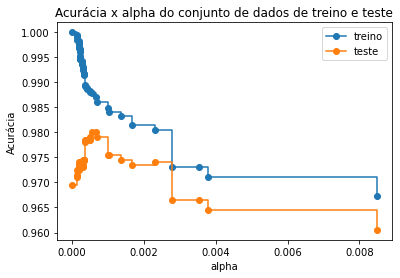

In [14]:
#Loop de treino e teste para gerar lista de acurácias
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

#Buscando o melhor alpha que não esteja com overfiting
deltas = [train_scores[i] - test_scores[i] for i in range(len(ccp_alphas))]
min_delta = min(deltas)
best_alpha = ccp_alphas[deltas.index(min_delta)]
print(best_alpha)

#Plotando um gráfico para analisar a Acurácia com o alphas de treino e teste
fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("Acurácia")
ax.set_title("Acurácia x alpha do conjunto de dados de treino e teste")
ax.plot(ccp_alphas, train_scores, marker='o', label="treino",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="teste",
        drawstyle="steps-post")
ax.legend()
plt.show()

#### Utilizando o melhor ccp_alpha geramos uma árvore podada e com a melhor acurácia, diminuindo assim a chance de overfiting.

Acurácia do modelo: 0.9665167416291854


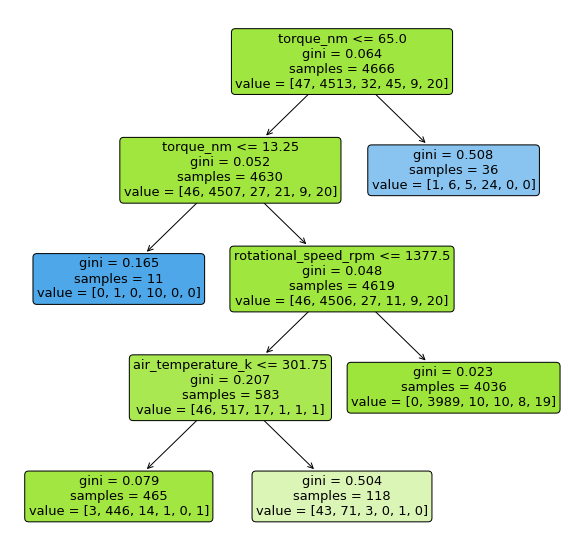

In [15]:
#Testando a nova árvore podada
clf1_podada = DecisionTreeClassifier(random_state=123, ccp_alpha= best_alpha)

clf1_podada.fit(X_train, y_train)
predict = clf1_podada.predict(X_test)
acc = accuracy_score(y_test, predict)
print("Acurácia do modelo:", acc)

#Plotando a nova árvore
plt.figure(figsize=[10,10])
plot_tree(clf1_podada,
         filled=True,
         rounded=True,
         feature_names=X_train.columns);

#### A matriz de confusão demonstra como está bem preciso o modelo, demonstrando que em poucos casos houve o engano de falhas.

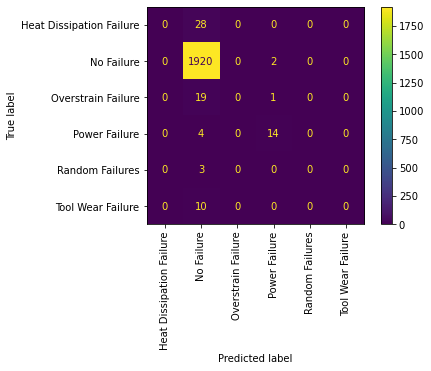

In [16]:
#Matriz de confusão
plot_confusion_matrix(clf1_podada, X_test, y_test,xticks_rotation='vertical')


#### Utilizando os dados do Data Frame de teste para gerar a resposta do problema:


In [17]:
# Criando o data frame com os novos testes e predizendo.
new_data = df_test_encoded.drop(['udi', 'product_id'], axis=1)
predictions = clf1_podada.predict(new_data)
predictions

#Criando um data frame com os resultados
row_numbers = [i for i in range(len(predictions))]
df = pd.DataFrame({'Row Number': row_numbers, 'predicted Values': predictions})

# Salva o dataframe em um arquivo CSV
df.to_csv('predicted1.csv', index=False)

#### Salvando a árvore para usar em um script

In [18]:
# Salvando a árvore de decisão treinada com pickle
with open('clf1.pickle', 'wb') as f:
 pickle.dump(clf1_podada, f)

# Variação cruzada K-fold <a name="k-fold"></a>
<div style="text-align: right"
     
[Voltar ao índice](#Contents)

####  Como não temos os y_teste, utilizar a validação cruzada é uma opção para treinar toda base oferecida, vamos treinar o modelo utilizando a validação cruzada com o método de "K-fold". O métdo K-fold divide a base de treino em várias e treina entre elas mesmo obtendo vários resultados e tirando a média da acurácia.

In [19]:
X = df_treino_encoded.drop(['failure_type','udi','product_id'], axis=1) # variáveis independentes e retirando as não utilizadas
y = df_treino_encoded['failure_type'] # a variável alvo

# Intanciando a árvore
dt_clf = DecisionTreeClassifier(random_state = 777)

# Inicializar o objeto KFold
kf = KFold(n_splits=5)

# Array para armazenar as métricas de avaliação
scores = []

# Loop de treinamento do modelo
for train_index, test_index in kf.split(X):
    X_train_k = X.iloc[train_index,:]
    X_test_k = X.iloc[test_index,:]
    y_train_k = y[train_index]
    y_test_k = y[test_index]
    
    dt_clf.fit(X_train_k, y_train_k)
    y_pred = dt_clf.predict(X_test_k)
    
# Avaliação da acurácia média e do desvio padrão
accuracies = cross_val_score(estimator=dt_clf, X=X, y=y, cv=kf, scoring='accuracy')
mean_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies)
print("Acurácia média:", mean_accuracy)
print("Desvio padrão da acurácia:", std_accuracy)

Acurácia média: 0.9663990210446164
Desvio padrão da acurácia: 0.01696143468541342


#### A validação cruzada utilizando o método "K-fold" é bem robusta, pois utiliza todos os dados disponíveis no treino. E com a Acurácia Média em 0.96 desvio padrão baixo de 0.017 indica um bom modelo que não apresenta overfiting.

#### Resolvendo o problema com os novos dados na nova árvore :

In [20]:
# Testando o modelo com os dados da planilha teste
dt_y = dt_clf.predict(new_data)
dt_y
# Salvando os resultados
df2 = pd.DataFrame({'rowNumber': range(len(dt_y)), 'predictedValues': dt_y})
df2 = df2.to_csv('predicted.csv', index=False)

#### Salvando a árvore para usar em um script

In [21]:
# Salvando a árvore de decisão treinada com pickle
with open('dt_clf.pickle', 'wb') as f:
 pickle.dump(dt_clf, f)

# Prós e Contras, qual usar ? <a name="prós"></a>
<div style="text-align: right"
     
[Voltar ao índice](#Contents)

### Como vimos os dois modelos utilizam a árvore de decisão e passaram por treinamento e testes além de buscar a minimização de problemas de treino como o overfiting. Os Resultados de acurácia dos modelos foram bem parecidos, e os prós e contras ajudará a decidir qual melhor modelo:


## Algumas vantagens das árvores de decisão são:
•Simples de entender e interpretar. As árvores podem ser visualizadas.

•Requer pouca preparação de dados. Outras técnicas geralmente requerem normalização de dados, variáveis dummie(flag) precisam ser criadas e valores em branco precisam ser removidos.

•Capaz de lidar com dados numéricos e categóricos. Outras técnicas geralmente são especializadas na análise de conjuntos de dadosque possuem apenas um tipo de variável.

•Capaz de lidar com problemas de múltiplas saídas.

•Usa um modelo de caixa branca. Se uma determinada situação é observável em um modelo, a explicação para a condição é facilmente explicada pela lógica booleana. Por outro lado, em um modelo de caixa preta (por exemplo, em uma rede neural), os resultados podem ser mais difíceis de interpretar.
## As desvantagens das árvores de decisão incluem:
•As árvores de decisão podem ser tão complexas que não generalizam bem os dados. Isso é chamado de overfitting. Mecanismos como poda, definir o número mínimo de amostras necessárias numa folha ou definir a profundidade máxima da árvore são necessários paraevitar este problema.

•As árvores de decisão podem ser instáveis, pois pequenas variações nos dados podem resultar na geração de uma árvore completamente diferente.

•As previsões das árvores de decisão não são suaves nem contínuas. Portanto, eles não são bons em extrapolação.

•As árvores de decisão podem ser enviesadas se algumas classes dominam no conjunto de dados. Portanto, é recomendável equilibrar o conjunto de dados antes de ajustá-lo à árvore de decisão.

## K-fold x Split

#### A escolha depende de vários fatores, incluindo o tamanho da sua base de dados, o objetivo do modelo e o grau de incerteza que você está disposto a aceitar. Em geral, a validação cruzada com o método K-fold é uma abordagem mais robusta, pois ajuda a evitar overfitting e fornece uma estimativa mais precisa da performance do modelo. No entanto, a divisão da base em treinamento e teste é mais fácil e rápida de implementar e pode ser adequada para conjuntos de dados menores.

#### Por esse motivo iremos utilizar o K-fold pois ele valoriza mais a quantidade de dados o que torna um modelo mais forte.